In [1]:
import numpy as np
import random
import datetime

class Task():
    
    def __init__(self,n_hidden_features,tasktype,curve1=[],curve2=[]):
        
        self.grid_size = 7
        self.n_hidden_features = n_hidden_features
        self.number_color = self.n_hidden_features - 2 # 1 or 2, colors of the fixation point
        
        
        self.state = 0
        self.counter = 0
        self.trialEnd = False

        self.onestep = True
        

        self.states = {'intertrial', 'waitfix', 'fix', 'mem', 'go'}
        self.state = 'intertrial'
        
        self.curve_length = 2
        self.delay = 1
        self.turnoff_fp = True
        self.same_length_distr = True
        self.force_wait = 1
        self.n_actions = self.grid_size ** 2
        
        self.onlyblue = False
        
        self.intertrial_dur = 0
        self.fix_dur = 0
        self.waitfix_timeout = 5
        self.max_dur = 0
        
        self.cur_reward = 0
        self.fix_reward = 0.2
        self.fin_reward = 1.5
        
        self.total_trials = 0
        self.correct_trials = 0
        
        self.flowcontrol = {'intertrial': self.do_intertrial,
                            'waitfix': self.do_waitfix,
                            'fix': self.do_fix,
                            'go': self.do_go,
                            'go_onestep': self.do_go_onestep}
        
        self.distr_curv_on = True
        
        self.tasktype = tasktype
        if self.tasktype != 'searchtrace' and self.tasktype != 'trace':
            raise Exception('Task type must be either searchtrace or trace')

        if self.tasktype == 'trace':
          self.tasktypeBool = 1
        else:
          self.tasktypeBool = 0

        self.nwInput = np.zeros((1,self.grid_size ** 2 + self.tasktypeBool+1, self.n_hidden_features))
        
        self.CheckDistance = 'no'     
        
        self.CurveDeterminedOutside = False
        
        if len(curve1) > 0:
            self.CurveDeterminedOutside = True
            self.curve1 = curve1
            self.curve2 = curve2

    def stateReset(self):
        self.trialEnd = True
        self.counter = 0
        self.nwInput = np.zeros((1,self.grid_size ** 2 + self.tasktypeBool+1, self.n_hidden_features))
        self.state = 'intertrial'
        self.total_trials = self.total_trials + 1

        
    def doStep(self,action):
        self.trialEnd = False
        self.flowcontrol[self.state](action)
        reward = self.cur_reward
        nwInput = self.nwInput.copy()
        trialEnd = self.trialEnd
        self.cur_reward = 0
        return(nwInput,reward,trialEnd)
    
    def do_intertrial(self,action):
        if self.counter == self.intertrial_dur:
            if self.CheckDistance != 'no' and self.CheckDistance != 'close' and self.CheckDistance != 'far':
                raise Exception('Checkdistance must be no or close or far') 
            if self.CheckDistance == 'close':
                condi = 6
                while condi > 5:
                    self.pickTrialType()
                    dist = self.ComputeDistance()
                    condi = np.max(dist)
            elif self.CheckDistance == 'far':
                condi = 0
                while condi < 5:
                    self.pickTrialType()
                    dist = self.ComputeDistance()
                    condi = np.min(dist)                
            else:
                self.pickTrialType()
            if self.onestep == False:
              self.nwInput[:,self.fix_point,self.feature_target] = 1 #Fixation point
              self.state = 'fix'
            else:
              self.nwInput = self.target_display.copy() 
              self.state = 'go_onestep'
            self.counter = 0  
        else:
            self.counter = self.counter + 1
            
    def do_waitfix(self,action):
        if self.counter <= self.waitfix_timeout:
            if action[0,self.fix_point] == 1: #fixation
                self.state = 'fix'
                self.counter = 0
            else:
                self.counter = self.counter + 1
        else:
            self.stateReset()
            
    def do_fix(self,action):
        if action[0,self.fix_point] != 1:
            self.stateReset()
        else:
            if self.counter == self.fix_dur:
                self.cur_reward = self.cur_reward + self.fix_reward
                self.counter = 0
                self.state = 'go'
                self.nwInput = self.target_display.copy()
            else:
                self.counter = self.counter + 1
            
    def do_go(self,action):
        ##Only the last saccade, see matlab for step by step tracing
        if self.counter <= self.max_dur:
            if action[0,self.fix_point] != 1:
                if np.where(action == 1)[1] == self.trialTarget[-1] and (self.counter >= self.delay or self.force_wait == 0):
                    self.correct_trials = self.correct_trials + 1
                    self.cur_reward = self.cur_reward + self.fin_reward * 0.8
                    #print('One trial success')
                    self.stateReset()
                else:
                    self.stateReset()
            else:
                self.counter = self.counter + 1
                if self.counter == self.delay and self.force_wait:
                    self.cur_reward = self.cur_reward + self.fix_reward
                    if self.turnoff_fp:
                        self.nwInput[:,self.fix_point,self.feature_target] = 0.5                   
                        if self.tasktype == 'trace': 
                            self.nwInput[:,self.fix_point,self.number_color] = 1 # green      
                        else:
                            self.nwInput[:,self.trialDistr[0],1 - self.feature_target] = 0.5 
                            self.nwInput[:,self.trialTarget[0],self.feature_target] = 0.5
                            
                if self.counter >= self.curve_length + 10:
                    self.stateReset()
        else:
            self.stateReset()

    def do_go_onestep(self,action):
        ##Only the last saccade, see matlab for step by step tracing
        if self.counter <= 0:
            if action[0,self.fix_point] != 1:
                if np.where(action == 1)[1] - 2 == self.trialTarget[-1] and (self.counter >= 0 or self.force_wait == 0):
                    self.correct_trials = self.correct_trials + 1
                    self.cur_reward = self.cur_reward + self.fin_reward * 0.8
                    #print('One trial success')
                    self.stateReset()
                else:
                    self.stateReset()
            else:
                self.counter = self.counter + 1
                if self.counter >= 0:
                    self.stateReset()
        else:
            self.stateReset()
        
    def pickTrialType(self):
        self.position = 0#np.random.randint(2)
        if self.onlyblue:
            red_pos = np.random.randint(self.grid_size**2)
            blue_pos = np.random.randint(self.grid_size**2)
            targ_display = np.zeros((1,self.grid_size ** 2 + self.tasktypeBool+1, self.n_hidden_features))
            while blue_pos == red_pos:
                blue_pos = np.random.randint(self.grid_size**2)
            self.feature_target = np.random.randint(self.number_color)
            targ_display[:,red_pos + self.tasktypeBool+1,self.feature_target] = 1
            targ_display[:,blue_pos + self.tasktypeBool+1,self.number_color + 1] = 1
            if self.tasktype == 'trace':
                targ_display[:,self.position,self.feature_target] = 1                  
            self.target_display = targ_display
            self.trialTarget = [red_pos, blue_pos]
            self.fix_point = self.trialTarget[0]
        else:
            if self.CurveDeterminedOutside == False:
                while True:
                  try:
                    mask = np.zeros((self.grid_size,self.grid_size))
                    curve1, mask1 = self.make_curves([],mask,self.curve_length)
                    curve2, mask2 = self.make_curves([],mask1,self.curve_length)
                    break
                  except IndexError:
                    pass 
            else:
                curve1 = self.curve1
                curve2 = self.curve2
            self.feature_target = np.random.randint(self.number_color)
            targ_display = np.zeros((1,self.grid_size ** 2 + self.tasktypeBool+1, self.n_hidden_features))
            for i in range(len(curve1)):
                if i == 0: #red
                    targ_display[:,curve1[0] + self.tasktypeBool+1,0] = 1
                elif i == len(curve1)-1: #blue
                     targ_display[:,curve1[i] + self.tasktypeBool+1,self.number_color + 1] = 1
                else: #green
                    targ_display[:,curve1[i] + self.tasktypeBool+1,self.number_color] = 1
            for i in range(len(curve2)):
                if i == 0:
                    targ_display[:,curve2[0] + self.tasktypeBool+1,1] = 1 # Either green or yellow, so always second array
                elif i == len(curve2)-1:
                    targ_display[:,curve2[i] + self.tasktypeBool+1,self.number_color + 1] = 1
                else:
                    targ_display[:,curve2[i] + self.tasktypeBool+1,self.number_color] = 1
            if self.number_color == 1:
                self.trialTarget = curve1
                self.trialDistr = curve2
                if self.tasktype == 'trace':
                    self.fix_point = self.trialTarget[0]
            else:
                if self.feature_target == 0:
                    self.trialTarget = curve1
                    self.trialDistr = curve2
                    if self.tasktype == 'trace':
                        self.fix_point = self.trialTarget[0]
                        targ_display[:,self.position,self.feature_target] = 1
                    targ_display[:,self.fix_point+ self.tasktypeBool+1 ,0] = 1
                else:
                    self.trialTarget = curve2
                    self.trialDistr = curve1
                    if self.tasktype == 'trace':
                        self.fix_point = self.trialTarget[0]
                        targ_display[:,self.position,self.feature_target] = 1
                    targ_display[:,self.fix_point+ self.tasktypeBool+1 ,1] = 1
            self.target_display = targ_display
            
    def make_curves(self,curve,mask_original,curvelength):
      mask = mask_original.copy()
      if len(curve) == 0:
        x,y = np.where(mask == 0)
        ind = np.random.randint(len(x))
        first_elem = x[ind] + y[ind] * self.grid_size
        mask[first_elem % self.grid_size,first_elem // self.grid_size] = 1
        curve.append(first_elem)
        return self.make_curves(curve,mask,curvelength)
      else:
        xend = curve[-1] % self.grid_size
        yend = curve[-1] // self.grid_size
        consecutivesx = [xend - 1,xend + 1]
        consecutivesx = [i for i in consecutivesx if i >= 0 and i < self.grid_size]
        consecutivesy = [yend - 1,yend + 1]
        consecutivesy = [i for i in consecutivesy if i >= 0 and i < self.grid_size]
        while len(curve) < curvelength : #We append one at the end
          possible_next_value = []
          for i in range(len(consecutivesx)):
              if  mask[consecutivesx[i],yend] == 0:
                possible_next_value.append((consecutivesx[i],yend))
          for i in range(len(consecutivesy)):
              if  mask[xend,consecutivesy[i]] == 0:
                possible_next_value.append((xend,consecutivesy[i]))
          next_value = random.choice(possible_next_value)
          curve.append(next_value[0] + next_value[1] * self.grid_size)
          for i in range(len(possible_next_value)):
            mask[possible_next_value[i][0],possible_next_value[i][1]] = 1
          return self.make_curves(curve,mask,curvelength)
        else:
            for i in range(len(consecutivesx)):
                mask[consecutivesx[i],yend] = 1
            for i in range(len(consecutivesy)):
                mask[xend,consecutivesy[i]] = 1
            return curve, mask

    def ComputeDistance(self):
        target = self.trialTarget
        distr = self.trialDistr
        dist = np.zeros((len(target),len(distr)))        
        for i in range(len(target)):
            for j in range(len(distr)):
                if target[i] % self.grid_size != 0:
                    xtarget = np.floor(target[i]/self.grid_size) 
                    ytarget = target[i] % self.grid_size
                else:
                    xtarget =  np.floor(target[i]/self.grid_size)
                    ytarget = 0
                if distr[j] % self.grid_size != 0:
                    xdistr = np.floor(distr[j]/self.grid_size)
                    ydistr = distr[j] % self.grid_size
                else:
                    xdistr =  np.floor(distr[j]/self.grid_size)
                    ydistr = 0
                dist[i,j] = np.sqrt((xtarget - xdistr)**2 + (ytarget - ydistr)**2)
        return dist

In [2]:

import numpy as np

class Network():
    def __init__(self,n_input_features):
        self.dotrain = True
        
        self.beta = 0.2
        self.gamma = 0.9
        self.lambda_var = 0
        self.n_input_features = n_input_features
        self.n_hidden_features = 4
        
        self.xy_weight_range = 0.1
        self.yz_weight_range = 0.1
        
        self.bias_input = 1
        self.bias_hidden = 1
        
        self.controller = 'max-boltzmann'
        self.exploit_prob = 0.95
        
        self.limit_delta = False
        self.delta_limit = 0.5
        self.use_class_connection = True
        self.constrain_q_acts = False
        
        self.prec_q_acts = 1e8
        self.grid_size = 7
        
        
        self.n_inputs = self.grid_size ** 2 + 2
        self.nx = self.grid_size ** 2 + 2
        self.ny_normal = self.grid_size ** 2 + 2
        self.ny = self.grid_size ** 2 + 2
        self.nz = self.grid_size ** 2 + 2

        self.instant_transform_fn = 'rectified-linear'
        self.instant_transform_tau = 2.5
        self.setInstantTransform(self.instant_transform_fn,self.instant_transform_tau)
        
        self.v1 = np.zeros((self.nx+self.bias_input,self.ny,self.n_input_features,self.n_hidden_features))
        self.t1 = np.zeros((self.nx,self.ny,self.n_input_features,self.n_hidden_features))
        self.u1 = np.zeros((self.ny+self.bias_input,self.nx,self.n_input_features,self.n_hidden_features))
        self.u1mod = np.zeros((self.ny,self.nx,self.n_input_features,self.n_hidden_features))
        
        self.v2 = np.zeros((self.ny+self.bias_input,self.ny,self.n_hidden_features,self.n_hidden_features)) 
        self.t2 = np.zeros((self.ny,self.ny,self.n_hidden_features,self.n_hidden_features)) 
        self.u2 = np.zeros((self.ny+self.bias_input,self.ny,self.n_hidden_features,self.n_hidden_features)) 
               
        self.w = np.zeros((self.ny+self.bias_hidden,self.nz,self.n_hidden_features))
        
        self.v1_class =  np.zeros((self.nx+1,self.ny,self.n_input_features))
        self.t1_class =  np.zeros((self.nx,self.ny))
        self.u1_class = np.zeros((self.ny+1,self.nx,self.n_hidden_features))
        self.u1mod_class = np.zeros((self.ny,self.nx))
        self.v2_class =  np.zeros((self.ny+1,self.ny,self.n_hidden_features))
        self.t2_class = np.zeros((self.ny,self.ny))
        self.u2_class = np.zeros((self.ny+1,self.ny,self.n_hidden_features))
        self.w_class = np.zeros((self.ny+1,self.nz,self.n_hidden_features))
        
        self.v1_mask = np.zeros_like(self.v1)
        self.t1_mask = np.zeros_like(self.t1)
        self.u1_mask = np.zeros_like(self.u1)
        self.u1mod_mask = np.zeros_like(self.u1mod)
        self.v2_mask = np.zeros_like(self.v2)
        self.t2_mask = np.zeros_like(self.t2)
        self.u2_mask = np.zeros_like(self.u2)
        self.w_mask = np.zeros_like(self.w)
           
        self.limit_traces = True
        
        self.backprop_length = 4
        
        self.old_qas = -np.ones((1,self.nz))
        
        self.delta = 0

        self.input_method = 'modulcells_on_reg'

        self.current_input = np.zeros((1,self.n_inputs))
        self.prev_input = np.zeros((1,self.n_inputs))
        self.prev_action_probs = np.zeros((1,self.nz)) / self.nz
        self.prev_action_prob = self.prev_action_probs[0,0]
        self.prev_action = 0
        self.previous_qa = 0
        self.qas = np.zeros((1,self.nz))
        
        self.init_weights()
        
    def doStep(self):
        raise NotImplementedError('Parent method')
    
    def calc_Input(self):
        raise NotImplementedError('Parent method')
        
    def calc_Hiddens(self):
        raise NotImplementedError('Parent method')
        
    def calc_Output(self):
        raise NotImplementedError('Parent method')

    def calc_maxQ(self):
        max_q = np.max(self.qas)
        winner = np.argmax(self.qas)
        self.prev_action_prob = self.exploit_prob
        
        #Break ties randomly
        indexs = np.where(self.qas[0,:] == max_q)
        if len(indexs[0]) > 1:
            winner = indexs[0][np.random.randint(len(indexs[0]))]
        return winner
    
    def calc_softWTA(self,probabilities):
        # Create wheel:
        probs = [sum(probabilities[0,:i + 1]) for i in range(len(probabilities[0]))]

        # Select from wheel
        rnd = np.random.rand()
        for (i, prob) in enumerate(probs):
            if rnd <= prob:
                return i
            
    def init_weights(self):
        
        # Making the nearest neighbours connection matrix
        X, Y = np.meshgrid(np.arange(0, self.grid_size, 1),np.arange(0, self.grid_size, 1))
        X = X.reshape((1,self.grid_size ** 2))
        Y = Y.reshape((1,self.grid_size ** 2))
        diffX =np.abs(np.dot(np.ones((self.grid_size**2,1)),X) - np.dot(X.T,np.ones((1,self.grid_size**2))))
        diffY = np.abs(np.dot(np.ones((self.grid_size**2,1)),Y) - np.dot(Y.T,np.ones((1,self.grid_size**2))))
        W = np.sqrt(diffX ** 2 + diffY ** 2)
        
        class_connection = np.zeros_like(W)
        class_connection[np.abs(W < 1.01)] = 2
        class_connection[np.abs(W < 0.01)] = 1
        W[np.abs(W) < 1.001] = 1
        
        for f in range(self.n_input_features):
            self.v1_class[3:,2:,f] = class_connection
            self.v1_class[3:,:2,f] = 3
            self.v1_class[3:,1,f] = 4
            self.v1_class[1,0,f] = 5
            self.v1_class[2,1,f] = 6
            #self.v1_class[1,1,f] = 6
            #self.v1_class[2,0,f] = 6
            #self.v1_class[3:,1,f] = 4

        for f in range(self.n_hidden_features):    
            self.u1_class[3:,2:,f] = class_connection
            self.u1_class[1,2:,f] = 3
            self.u1_class[2,2:,f] = 4
            self.u1_class[1,0,f] = 5
            self.u1_class[2,1,f] = 6
            
            
            self.v2_class[3:,2:,f] = class_connection
            self.v2_class[3:,0,f] = 3
            self.v2_class[3:,1,f] = 4
            self.v2_class[1,0,f] = 5
            self.v2_class[2,1,f] = 6
            #self.v2_class[1,1,f] = 6
            #self.v2_class[2,0,f] = 6            
            #self.v2_class[3:,1,f] = 4
            
            self.u2_class[3:,2:,f] = class_connection
            self.u2_class[1,2:,f] = 3
            self.u2_class[2,2:,f] = 4
            self.u2_class[1,0,f] = 5
            self.u2_class[2,1,f] = 6

            self.w_class[3:,2:,f] = np.diag(np.ones(self.grid_size**2)) + 1
            self.w_class[3:,0,f] = 3
            self.w_class[3:,1,f] = 4
            
            self.w_class[1,0,f] = 5
            self.w_class[2,1,f] = 6
            #self.w_class[1,1,f] = 6
            #self.w_class[2,0,f] = 6
            #self.w_class[3:,1,f] = 4

        self.v1_class[0,2:,0] = 7
        self.v1_class[0,0,0] = 8
        self.v1_class[0,1,0] = 9
        
        self.u1_class[0,2:,0] = 7
        self.u1_class[0,0,0] = 8
        self.u1_class[0,1,0] = 9
        
        self.v2_class[0,2:,0] = 7
        self.v2_class[0,0,0] = 8
        self.v2_class[0,1,0] = 9
        
        self.u2_class[0,2:,0] = 7
        self.u2_class[0,0,0] = 8
        self.u2_class[0,1,0] = 9
        
        self.w_class[0,2:,0] = 7
        self.w_class[0,0,0] = 8
        self.w_class[0,1,0] = 9

        self.t1_class[2:,2:] = class_connection
        self.t1_class[2:,0] = 3
        self.t1_class[2:,1] = 4
        self.t1_class[0,0] = 5
        self.t1_class[1,1] =6
        
        self.u1mod_class[2:,2:] = class_connection
        self.u1mod_class[0,2:] = 3
        self.u1mod_class[1,2:] = 4
        self.u1mod_class[0,0] = 5
        self.u1mod_class[1,1] = 6
        
        #self.t1_class[0,1] = 6
        #self.t1_class[1,0] = 6
        #self.t1_class[2:,1] = 4
        
        #self.u1_class[0,1] = 6
        #self.u1_class[1,0] = 6
        #self.u1_class[1,2:] = 4
       
        self.t2_class[2:,2:] = class_connection
        self.t2_class[2:,0] = 3
        self.t2_class[2:,1] = 4
        
        self.t2_class[0,0] = 5
        self.t2_class[1,1] = 6
        #self.t2_class[0,1] = 6
        #self.t2_class[1,0] = 6
        #self.t2_class[2:,1] = 4
        #self.u2_class[0,1] = 6
        #self.u2_class[1,0] = 6
        #self.u2_class[2:,1] = 4
        
        
        
        #Setting up the weights
        for conn_type in range(1,13):
            for f2 in range(self.n_hidden_features):
                for f in range(self.n_input_features):   
                        self.v1[self.v1_class[:,:,f] == conn_type,f,f2] = np.random.rand() * self.xy_weight_range
                        self.t1[self.t1_class == conn_type,f,f2] = np.random.rand() * self.xy_weight_range
                        self.u1[self.u1_class[:,:,f2] == conn_type,f,f2] = np.random.rand() * self.xy_weight_range
                        self.u1mod[self.u1mod_class == conn_type,f,f2] = np.random.rand() * self.xy_weight_range
                for f in range(self.n_hidden_features):     
                        self.v2[self.v2_class[:,:,f] == conn_type,f,f2] =  np.random.rand() * self.yz_weight_range
                        self.t2[self.t2_class == conn_type,f,f2] =  np.random.rand() * self.yz_weight_range
                        self.u2[self.u2_class[:,:,f2] == conn_type,f,f2] =  np.random.rand() * self.yz_weight_range
            
            for f in range(self.n_hidden_features):                             
                if conn_type in [1,3,4]:
                    self.w[self.w_class[:,:,f] == conn_type,f] = -np.random.rand() * self.yz_weight_range / 10
                else:
                    self.w[self.w_class[:,:,f] == conn_type,f] = np.random.rand() * self.yz_weight_range

#        for f2 in range(self.n_hidden_features):
#            for f in range(self.n_input_features):   
#            
#                self.v1[1,0,f,f2] = np.random.rand() * self.xy_weight_range
#                self.v1[2,1,f,f2] = np.random.rand() * self.xy_weight_range
                #self.v1[0,0,0,f] = np.random.rand() * self.xy_weight_range
                #self.v1[0,1,0,f] = np.random.rand() * self.xy_weight_range
                
#                self.t1[0,0,f,f2] = np.random.rand() * self.xy_weight_range
#                self.t1[1,1,f,f2] = np.random.rand() * self.xy_weight_range
#                self.u1[0,0,f,f2] = np.random.rand() * self.xy_weight_range
#                self.u1mod[0,0,f,f2] = np.random.rand() * self.xy_weight_range
                
#                self.u1[1,1,f,f2] = np.random.rand() * self.xy_weight_range
#                self.u1mod[1,1,f,f2] = np.random.rand() * self.xy_weight_range
                
#            for f in range(self.n_hidden_features):     
#                self.v2[1,0,f,f2] = np.random.rand() * self.xy_weight_range
#                self.v2[2,1,f,f2] = np.random.rand() * self.xy_weight_range
                #self.v2[0,0,0,f] = np.random.rand() * self.xy_weight_range
                #self.v2[0,1,0,f] = np.random.rand() * self.xy_weight_range
                
#                self.t2[0,0,f,f2] = np.random.rand() * self.xy_weight_range
#                self.u2[0,0,f,f2] = np.random.rand() * self.xy_weight_range
                
#                self.t2[1,1,f,f2] = np.random.rand() * self.xy_weight_range
#                self.u2[1,1,f,f2] = np.random.rand() * self.xy_weight_range
                
#            self.w[1,0,f2] = np.random.rand() * self.xy_weight_range
#            self.w[2,1,f2] = np.random.rand() * self.xy_weight_range
            #self.w[0,0,f2] = np.random.rand() * self.xy_weight_range
            #self.w[0,1,f2] = np.random.rand() * self.xy_weight_range
        

        self.v1_mask[np.nonzero(self.v1)] = 1
        self.t1_mask[np.nonzero(self.t1)] = 1
        self.u1_mask[np.nonzero(self.u1)] = 1
        self.u1mod_mask[np.nonzero(self.u1mod)] = 1
        self.v2_mask[np.nonzero(self.v2)] = 1
        self.t2_mask[np.nonzero(self.t2)] = 1
        self.u2_mask[np.nonzero(self.u2)] = 1
        self.w_mask[np.nonzero(self.w)] = 1
        
        
    def relu(self,x):
        thresh = 6
        xx = x.copy()
        xx[xx < 0] = 0
        xx[thresh <= xx] = np.log(1.5*xx[thresh <= xx] + 1) + thresh - np.log(1.5 * thresh + 1)
        return xx
    
    def reluderivative(self,x):
        thresh = 6
        xx = x.copy()
        xx[xx <= 0] = 0
        xx[(0 < xx) & (x < thresh)] = 1
        xx[thresh <= xx] = 1.5/(1.5 * xx[thresh <= xx] + 1)
        return xx

    def setInstantTransform(self,func,tau=2):
        if func == 'rectified-linear':
            self.hd_transform_normal = self.relu
            self.hd_transform_normal_deriv = self.reluderivative
        else:
            raise Exception("self.instant_transform_fn")

class CT_DeepNet2(Network):
    
    def __init__(self,n_hidden_features):
        
        super().__init__(n_hidden_features)
        
        self.X = np.zeros((1,self.nx+1,self.n_input_features))
        self.X[0,0,:] = 1 #Bias
        self.Xmod = np.zeros((1,self.nx,self.n_input_features))
        self.Y1 = np.zeros((1,self.ny+1,self.n_hidden_features))
        self.Y1[0,0,:] = 1 #Bias
        self.Y1mod = np.zeros((1,self.ny,self.n_hidden_features))
        self.Y2 = np.zeros((1,self.ny+1,self.n_hidden_features))
        self.Y2[0,0,:] = 1 #Bias
        self.Z = np.zeros((1,self.nz-1))
        self.Col = np.ones((1,self.n_hidden_features))

        self.saveX = [[]]
        self.saveXmod = [[]]
        self.saveY1 = [[]]
        self.saveY1mod = [[]]
        self.saveY2 = [[]]
        self.saveQ = [[]]
        self.dosave = False
        
        self.Accessory_network = AccessoryNetwork(n_hidden_features)
        self.resetTraces()
        
        
    def doStep(self,input_env,reward,reset_traces):
        if self.n_inputs == len(input_env[0]):
            self.current_input = input_env.copy()
        else:
            raise Exception('Number of inputs does not match number of input neurons')
        
        norm = 0
        for i in range(5):
          self.calc_Input()
          
          self.calc_Hiddens()
          
          self.calc_Output()

          if self.dosave:
              if np.sum(self.current_input[:,:,0]) != 0:
                self.saveX[len(self.saveX) - 1].append(self.X.copy())
                self.saveXmod[len(self.saveXmod) - 1].append(self.Xmod.copy())
                self.saveY1[len(self.saveY1) - 1].append(self.Y1.copy())
                self.saveY1mod[len(self.saveY1mod) - 1].append(self.Y1mod.copy())
                self.saveY2[len(self.saveY2) - 1].append(self.Y2.copy())
                self.saveQ[len(self.saveQ) - 1].append(self.qas.copy())

          norm = np.linalg.norm(self.prev_y1[0,1:,-1]-self.Y1[0,1:,-1],np.inf)         

        while i<40:# and norm>0:# and prev_norm > norm:
          self.calc_Input()
          
          self.calc_Hiddens()
          
          self.calc_Output()

          if self.dosave:
              if np.sum(self.current_input[:,:,0]) != 0 or np.sum(self.current_input[:,:,1]) != 0  :
                self.saveX[len(self.saveX) - 1].append(self.X.copy())
                self.saveXmod[len(self.saveXmod) - 1].append(self.Xmod.copy())
                self.saveY1[len(self.saveY1) - 1].append(self.Y1.copy())
                self.saveY1mod[len(self.saveY1mod) - 1].append(self.Y1mod.copy())
                self.saveY2[len(self.saveY2) - 1].append(self.Y2.copy())
                self.saveQ[len(self.saveQ) - 1].append(self.qas.copy())

          norm = np.linalg.norm(self.prev_y1[0,1:,-1]-self.Y1[0,1:,-1],np.inf)  
          i += 1
        
        
        if self.dotrain:
            exp_value = self.qas[0,self.prev_action]
                
            if reset_traces:
                exp_value = 0
             
            self.delta = reward + (self.gamma * exp_value) - self.previous_qa
            
            self.v1  = self.v1  + self.beta * self.delta * self.v1_traces  * self.v1_mask
            self.t1  = self.t1  + self.beta * self.delta * self.t1_traces  * self.t1_mask
            self.u1  = self.u1  + self.beta * self.delta * self.u1_traces  * self.u1_mask
            self.u1mod  = self.u1mod  + self.beta * self.delta * self.u1mod_traces  * self.u1mod_mask
            
            self.v2  = self.v2  + self.beta * self.delta * self.v2_traces  * self.v2_mask
            self.t2  = self.t2  + self.beta * self.delta * self.t2_traces  * self.t2_mask
            self.u2  = self.u2  + self.beta * self.delta * self.u2_traces  * self.u2_mask

            self.w = self.w + self.beta * self.delta * self.w_traces * self.w_mask

            if reset_traces:
                self.resetTraces()
            else:
                self.update_traces()
                
            self.prev_input = self.current_input.copy()
                
            self.previous_qa = exp_value

        elif reset_traces and not self.dotrain:
          self.resetTraces()

        action = self.Z.copy()
        return action
            
            
            
    def calc_Input(self):
        self.prev_x = self.X.copy()
        self.prev_xmod = self.Xmod.copy()
        
        self.X[:,1:,:] = self.current_input.copy()
    
        for f in range(self.n_input_features):
            modul_input = np.zeros((1,self.n_inputs))
            for f2 in range(self.n_hidden_features):
                modul_input = modul_input + self.Y1[0,:,f2] @ self.u1[:,:,f,f2] + self.Y1mod[0,:,f2] @ self.u1mod[:,:,f,f2]
            modul_normal = modul_input * self.current_input[0,:,f] #Element wise
            modul_transformed = self.hd_transform_normal(modul_normal)
            self.Xmod[0,:,f] = modul_transformed.copy()
        
    
    def calc_Hiddens(self):
        self.prev_y1 = self.Y1.copy()
        
        # Level 1 
        for f in range(self.n_hidden_features):
            activations_normal = np.zeros((1,self.ny))
            for f2 in range(self.n_input_features):
                activations_normal = activations_normal + self.X[0,:,f2] @ self.v1[:,:,f2,f] + self.Xmod[0,:,f2] @ self.t1[:,:,f2,f]
            normal_transformed = self.hd_transform_normal(activations_normal)
            self.Y1[0,1:,f] = normal_transformed.copy()
    
            modul_input = np.zeros((1,self.ny))
            for f2 in range(self.n_hidden_features):
                modul_input = modul_input + self.Y2[0,:,f2] @ self.u2[:,:,f,f2]
            modul_normal = modul_input * self.Y1[0,1:,f]
            modul_transformed = self.hd_transform_normal(modul_normal)
            self.Y1mod[0,:,f] = modul_transformed.copy()
            
        # Level 2
        for f2 in range(self.n_hidden_features):
            activations_normal = np.zeros((1,self.ny))
            for f in range(self.n_hidden_features):
                activations_normal = activations_normal + self.Y1[0,:,f] @ self.v2[:,:,f,f2] + self.Y1mod[0,:,f] @ self.t2[:,:,f,f2]
            normal_transformed = self.hd_transform_normal(activations_normal)
            self.Y2[0,1:,f2] = normal_transformed.copy()
    
    def calc_Output(self):
        Z = np.zeros((1,self.nz))
        for f in range(self.n_hidden_features):
            Z = Z + self.Y2[0,:,f] @ self.w[:,:,f]
        
        #Z = np.delete(Z,0,axis = 1)
        Z = np.round(Z * self.prec_q_acts) / self.prec_q_acts
        
        if self.constrain_q_acts:
            Z[Z < 0] = 0
            
        winner = -1
        self.qas = Z.copy()
        ZZint = Z.copy()

        if self.controller == 'max-boltzmann':
            if np.random.rand() < self.exploit_prob:
                winner = self.calc_maxQ()
            else:
                ZZint -= np.max(ZZint)
                ZZint = np.exp(ZZint) / np.sum(np.exp(ZZint))
                winner = self.calc_softWTA(ZZint)
        else:
             raise Exception("Wrong controller")
             
        self.prev_action = winner
        self.Z =  np.zeros((1,self.nz))

        self.Z[0,winner] = 1
        #self.qas[0,np.setdiff1d(np.arange(self.nz),winner)] = 0



    def update_traces(self):
        #Decay the traces
        self.v1_traces = self.v1_traces * self.gamma * self.lambda_var
        self.t1_traces = self.t1_traces * self.gamma * self.lambda_var
        self.u1_traces = self.u1_traces * self.gamma * self.lambda_var
        self.u1mod_traces = self.u1mod_traces * self.gamma * self.lambda_var
        
        self.v2_traces = self.v2_traces * self.gamma * self.lambda_var
        self.t2_traces = self.t2_traces * self.gamma * self.lambda_var
        self.u2_traces = self.u2_traces * self.gamma * self.lambda_var

        self.w_traces = self.w_traces * self.gamma * self.lambda_var
            
        #Update the traces
        for f in range(self.n_hidden_features):
            self.w_traces[:,self.prev_action,f] = self.w_traces[:,self.prev_action,f]  + self.Y2[:,:,f].T[:,0]

        self.Accessory_network.SetActivities(self)
        self.Accessory_network.doStep(self.prev_action)

        for f in range(self.n_input_features):
          for f2 in range(self.n_hidden_features):
            self.v1_traces[:,:,f,f2] = self.v1_traces[:,:,f,f2] + self.X[:,:,f].T @ (self.Accessory_network.Y1[:,:,f2] * self.hd_transform_normal_deriv(self.Y1[:,1:,f2]))
            self.t1_traces[:,:,f,f2] = self.t1_traces[:,:,f,f2] + self.Xmod[:,:,f].T @ (self.Accessory_network.Y1[:,:,f2] * self.hd_transform_normal_deriv(self.Y1[:,1:,f2]))
            self.u1_traces[:,:,f,f2] = self.u1_traces[:,:,f,f2] + self.Y1[:,:,f2].T @ (self.Accessory_network.Xmod[:,:,f] *  self.hd_transform_normal_deriv(self.Xmod[:,:,f]) * self.X[:,1:,f])
            self.u1mod_traces[:,:,f,f2] = self.u1mod_traces[:,:,f,f2] + self.Y1mod[:,:,f2].T @ (self.Accessory_network.Xmod[:,:,f] *  self.hd_transform_normal_deriv(self.Xmod[:,:,f]) * self.X[:,1:,f])

        for f in range(self.n_hidden_features):
          for f2 in range(self.n_hidden_features):
            self.v2_traces[:,:,f,f2] = self.v2_traces[:,:,f,f2] + self.Y1[:,:,f].T @ (self.Accessory_network.Y2[:,:,f2] * self.hd_transform_normal_deriv(self.Y2[:,1:,f2]))
            self.t2_traces[:,:,f,f2] = self.t2_traces[:,:,f,f2] + self.Y1mod[:,:,f].T @ (self.Accessory_network.Y2[:,:,f2] * self.hd_transform_normal_deriv(self.Y2[:,1:,f2]))
            self.u2_traces[:,:,f,f2] = self.u2_traces[:,:,f,f2] + self.Y2[:,:,f2].T @ (self.Accessory_network.Y1mod[:,:,f] *  self.hd_transform_normal_deriv(self.Y1mod[:,:,f]) * self.Y1[:,1:,f])

        if self.use_class_connection:
          for conn_type in [1,2,3,4,5,6,7,8,9]:
              ind_t1 = np.where(self.t1_class == conn_type)
              ind_u1mod = np.where(self.u1mod_class == conn_type)
              ind_t2 = np.where(self.t2_class == conn_type)
              for f in range(self.n_input_features):
                  for f2 in range(self.n_hidden_features):
                        ind_v1 = np.where(self.v1_class[:,:,f] == conn_type)
                        ind_u1 = np.where(self.u1_class[:,:,f2] == conn_type)
                        self.v1_traces[ind_v1[0],ind_v1[1],f,f2] = np.mean(self.v1_traces[ind_v1[0],ind_v1[1],f,f2])

                        self.t1_traces[ind_t1[0],ind_t1[1],f,f2] = np.mean(self.t1_traces[ind_t1[0],ind_t1[1],f,f2])
                        
                        self.u1_traces[ind_u1[0],ind_u1[1],f,f2] = np.mean(self.u1_traces[ind_u1[0],ind_u1[1],f,f2])
                        
                        self.u1mod_traces[ind_u1mod[0],ind_u1mod[1],f,f2] = np.mean(self.u1mod_traces[ind_u1mod[0],ind_u1mod[1],f,f2])
                        
              for f in range(self.n_hidden_features):
                  ind_w = np.where(self.w_class[:,:,f] == conn_type)
                  for f2 in range(self.n_hidden_features):

                        ind_v2 = np.where(self.v2_class[:,:,f] == conn_type)
                        ind_u2 = np.where(self.u2_class[:,:,f2] == conn_type)
                        
                        self.v2_traces[ind_v2[0],ind_v2[1],f,f2] = np.mean(self.v2_traces[ind_v2[0],ind_v2[1],f,f2])

                        self.t2_traces[ind_t2[0],ind_t2[1],f,f2] = np.mean(self.t2_traces[ind_t2[0],ind_t2[1],f,f2])
                        
                        self.u2_traces[ind_u2[0],ind_u2[1],f,f2] = np.mean(self.u2_traces[ind_u2[0],ind_u2[1],f,f2])
                  
                  if (conn_type == 7 and f == 0) or (conn_type != 7):
                    self.w_traces[ind_w[0],ind_w[1],f] = np.mean(self.w_traces[ind_w[0],ind_w[1],f]) 




        if self.limit_traces:
          np.clip(self.w_traces,None,1,out=self.w_traces)
          np.clip(self.v1_traces,None,1,out=self.v1_traces)
          np.clip(self.t1_traces,None,1,out=self.t1_traces)
          np.clip(self.u1_traces,None,1,out=self.u1_traces)
          np.clip(self.u1mod_traces,None,1,out=self.u1mod_traces)

          np.clip(self.v2_traces,None,1,out=self.v2_traces)
          np.clip(self.t2_traces,None,1,out=self.t2_traces)
          np.clip(self.u2_traces,None,1,out=self.u2_traces)
                        
                
    def resetTraces(self):
        self.v1_traces = np.zeros((self.nx+self.bias_input,self.ny,self.n_input_features,self.n_hidden_features))
        self.t1_traces = np.zeros((self.nx,self.ny,self.n_input_features,self.n_hidden_features))
        self.u1_traces = np.zeros((self.ny+self.bias_input,self.nx,self.n_input_features,self.n_hidden_features))
        self.u1mod_traces = np.zeros((self.ny,self.nx,self.n_input_features,self.n_hidden_features))

        self.v2_traces = np.zeros((self.ny+self.bias_input,self.ny,self.n_hidden_features,self.n_hidden_features)) 
        self.t2_traces = np.zeros((self.ny,self.ny,self.n_hidden_features,self.n_hidden_features)) 
        self.u2_traces = np.zeros((self.ny+self.bias_input,self.ny,self.n_hidden_features,self.n_hidden_features)) 

        self.w_traces = np.zeros((self.ny+self.bias_hidden,self.nz,self.n_hidden_features))

        self.prev_input = np.zeros((1,self.n_inputs))

        self.X = np.zeros((1,self.nx+1,self.n_input_features))
        self.X[0,0,:] = 1 #Bias
        self.Xmod = np.zeros((1,self.nx,self.n_input_features))
        self.Y1 = np.zeros((1,self.ny+1,self.n_hidden_features))
        self.Y1[0,0,:] = 1 #Bias
        self.Y1mod = np.zeros((1,self.ny,self.n_hidden_features))
        self.Y2 = np.zeros((1,self.ny+1,self.n_hidden_features))
        self.Y2[0,0,:] = 1 #Bias

        if self.dosave:
          self.saveX.append([])
          self.saveXmod.append([])
          self.saveY1.append([])
          self.saveY1mod.append([])
          self.saveY2.append([])
          self.saveQ.append([])
        
        self.previous_qa = 0
        
            
class AccessoryNetwork(Network):
    
    def __init__(self,n_hidden_features):
      super().__init__(n_hidden_features)
      
      self.X = np.zeros((1,self.nx,self.n_input_features))
      self.Xmod = np.zeros((1,self.nx,self.n_input_features))
      self.Y1 = np.zeros((1,self.ny,self.n_hidden_features))
      self.Y1mod = np.zeros((1,self.ny,self.n_hidden_features))
      self.Y2 = np.zeros((1,self.ny,self.n_hidden_features))
      self.Z = np.zeros((1,self.nz))

      self.X_history = np.zeros((1,self.nx+1,self.n_input_features))
      self.Xmod_history = np.zeros((1,self.nx,self.n_input_features))
      self.Y1_history = np.zeros((1,self.ny+1,self.n_hidden_features))
      self.Y1mod_history = np.zeros((1,self.ny,self.n_hidden_features))
      self.Y2_history = np.zeros((1,self.ny+1,self.n_hidden_features))
 

    def doStep(self,input):
        self.current_input = input

        for i in range(self.backprop_length):
            self.calc_Input()
            
            self.calc_Hiddens()
            
            self.calc_Output()

    def calc_Input(self):
      prev_action = self.current_input
      for f in range(self.n_hidden_features):
        modul_input = np.zeros((1,self.ny))
        modul_input = modul_input + self.w[1:,prev_action,f].T
        for f2 in range(self.n_hidden_features):
          modul_input = modul_input + (self.Y1mod[0,:,f2] * self.hd_transform_normal_deriv(self.Y1mod_history[0,:,f2]) * self.Y1_history[0,1:,f2]) @ self.u2[1:,:,f2,f].T

        self.Y2[0,:,f] = modul_input

    def calc_Hiddens(self):
      for f in range(self.n_hidden_features):
        modul_input = np.zeros((1,self.ny))
        for f2 in range(self.n_hidden_features):
          modul_input = modul_input + (self.Y2[0,:,f2] * self.hd_transform_normal_deriv(self.Y2_history[0,1:,f2])) @ self.t2[:,:,f,f2].T 
        for f2 in range(self.n_input_features):
            modul_input = modul_input + (self.Xmod[0,:,f2] * self.hd_transform_normal_deriv(self.Xmod_history[0,:,f2]) * self.X_history[0,1:,f2]) @ self.u1mod[:,:,f2,f].T
        self.Y1mod[0,:,f] = modul_input

      for f in range(self.n_hidden_features):
        activations_normal = np.zeros((1,self.ny))
        for f2 in range(self.n_hidden_features):
          activations_normal = activations_normal + (self.Y2[0,:,f2] * self.hd_transform_normal_deriv(self.Y2_history[0,1:,f2])) @ self.v2[1:,:,f,f2].T 
          activations_normal = activations_normal + (self.Y2_history[0,:,f2] @ self.u2[:,:,f,f2]) * self.Y1mod[0,:,f] * self.hd_transform_normal_deriv(self.Y1mod_history[0,:,f])
        for f2 in range(self.n_input_features):
            activations_normal = activations_normal + (self.Xmod[0,:,f2] * self.hd_transform_normal_deriv(self.Xmod_history[0,:,f2]) * self.X_history[0,1:,f2]) @ self.u1[1:,:,f2,f].T
        self.Y1[0,:,f] = activations_normal

    def calc_Output(self):
      for f in range(self.n_input_features):
        modul_input = 0
        for f2 in range(self.n_hidden_features): 
          modul_input = modul_input + (self.Y1[0,:,f2] * self.hd_transform_normal_deriv(self.Y1_history[0,1:,f2])) @ self.t1[:,:,f,f2].T
        self.Xmod[0,:,f] = modul_input

    def SetActivities(self,n):
      self.X = np.zeros((1,self.nx,self.n_input_features))
      self.Xmod = np.zeros((1,self.nx,self.n_input_features))
      self.Y1 = np.zeros((1,self.ny,self.n_hidden_features))
      self.Y1mod = np.zeros((1,self.ny,self.n_hidden_features))
      self.Y2 = np.zeros((1,self.ny,self.n_hidden_features))
      
      self.X_history = n.X
      self.Xmod_history = n.Xmod
      self.Y1_history = n.Y1
      self.Y1mod_history = n.Y1mod
      self.Y2_history = n.Y2

      self.w = n.w
      self.v1 = n.v1
      self.t1 = n.t1
      self.u1 = n.u1
      self.u1mod = n.u1mod
      self.v2 = n.v2
      self.t2 = n.t2
      self.u2 = n.u2



In [4]:
import pandas as pd
from CT_DeepNet import *
df = pd.read_pickle("ResultsSearchTrace.pkl")

In [5]:
def RunTrials(t,CurveLength,TrialNumber,n):
    n.exploit_prob = 1
    n.dotrain = False
    n.dosave = True
    corrects = []
    target_history = []
    distr_history = []
    feature_history = []
    display = []
    t.curve_length = CurveLength
    new_input = t.nwInput
    t.feature_target = 0
    action = np.zeros((1,49));
    action[0] = 1;
    n.saveX = [[]]
    n.saveXmod = [[]]
    n.saveY1 = [[]]
    n.saveY1mod = [[]]
    n.saveY2 = [[]]
    n.saveQ = [[]]
    for p in range(TrialNumber):
      trial_running = True
      display.append([])
      feature_history.append(t.feature_target) 
      i=0
      while trial_running:
        new_input, reward, trialEnd = t.doStep(action)
        action = n.doStep(new_input,reward,trialEnd)
        display[p].append(n.X.copy())
        if trialEnd:
          trial_running = False
          if reward == 0:
            corrects.append(0)
          else:
            corrects.append(1)
        i = i + 1
      target_history.append(t.trialTarget)
      distr_history.append(t.trialDistr) 
    print(np.mean(corrects))
    return(n,corrects,feature_history,target_history,distr_history,display)  

In [6]:
Corrects = []
FeatureHist = []
TargetHist = []
DistrHist = []
SaveXmod = []
for k in range(len(df)):
    if df['TimeToConverge'][k]<175000:
        n = df['Network'][k]
        t = Task(4, 'trace')
        t.onestep = True
        t.onlyblue = False
        n,corrects,feature_history,target_history,distr_history,display = RunTrials(t,6,1000,n)
        Corrects.append(corrects)
        TargetHist.append(target_history)
        FeatureHist.append(feature_history)
        DistrHist.append(distr_history)
        curves = [np.zeros((1000,40)) for i in range(6)]
        ar = n.saveXmod
        for p in range(1,1000):
            if len(ar[p]) > 15:
                if corrects[p] == 1:
                    target_hist = target_history[p].copy()
                    distr_hist = distr_history[p].copy()
                    curvestemp = [np.zeros((40)) for i in range(6)]
                    for i in range(40):
                        if feature_history[p] == 0:
                            princ = 0
                            other = 1
                        else:
                            princ = 1
                            other = 0
                        curvestemp[0][i] = ar[p][i][0,target_hist[0]+2,princ] - ar[p][i][0,distr_hist[0]+2,other]
                        for l in range(1,6-1):
                            curvestemp[l][i] = ar[p][i][0,target_hist[l]+2,2] - ar[p][i][0,distr_hist[l]+2,2]
                        curvestemp[6-1][i] = ar[p][i][0,target_hist[6-1]+2,3] - ar[p][i][0,distr_hist[6-1]+2,3]
                    for l in range(6):
                        curves[l][p,:] = curvestemp[l]
        for l in range(6):
            curves[l] = curves[l][~np.all(curves[l] == 0, axis=1)]
        SaveXmod.append(curves)
    else:
        Corrects.append(0)
        TargetHist.append(0)
        DistrHist.append(0)
        FeatureHist.append(0)
        SaveXmod.append(0)      
    print(k)

0.891
0
0.868
1
0.899
2
0.908
3
0.885
4
0.934
5
0.88
6
0.972
7
0.884
8
0.902
9
0.866
10
0.947
11
0.853
12
0.94
13
0.882
14
0.914
15
0.968
16
0.85
17
0.874
18
0.857
19
0.977
20
0.84
21
0.886
22
0.882
23
0.882
24
0.867
25
0.848
26
0.921
27
0.929
28
0.954
29
0.857
30
0.838
31
0.913
32
0.86
33
0.888
34
0.909
35
0.88
36
0.861
37
0.909
38
0.889
39
0.886
40
0.874
41
0.986
42
0.864
43
0.965
44
0.913
45
0.868
46
1.0
47
0.89
48
0.824
49
0.867
50
0.85
51
0.941
52
0.892
53
0.921
54
0.921
55
0.914
56
0.866
57
0.959
58
0.896
59
0.875
60
61
62
0.855
63
0.886
64
65
0.881
66
0.876
67
68
69
70
0.92
71
72
73
74
0.876
75
76
77
78
0.862
79
80
81
82
0.897
83
84
85
86
87
88
89
90
91


In [7]:
resultsdict = {'Corrects':Corrects,'FeatureHist':FeatureHist,'TargetHist':TargetHist,'DistrHist':DistrHist,'SaveXmod':SaveXmod}

df2 = pd.DataFrame(resultsdict)
df2.to_pickle("ResultsSearchTraceNeuron.pkl")

In [8]:
df2.to_pickle("ResultsSearchTraceNeuron.pkl")

In [11]:

delays = np.zeros((60,5))
xx = np.linspace(0, 40, num=600)
for k in range(60):
    interpollated_curves = []   
    mean_normalized_curves = [np.mean(SaveXmod[k][l],axis=0)/np.max(np.abs(np.mean(SaveXmod[k][l],axis=0))) for l in range(6)]
    for i in range(6):
        interp = np.interp(xx, np.arange(0,40), mean_normalized_curves[i])
        interpollated_curves.append(interp)

    Y = []
    for i in range(1,6):
        if np.max(interpollated_curves[i])>=0.1:
            Y.append(xx[np.min(np.argwhere(interpollated_curves[i]>=0.1))])
        else:
            Y.append(np.nan)
    delays[k,:] = Y

In [12]:
np.nanmean(delays,axis=0)

array([3.36040293, 3.69089726, 5.38185111, 5.47805665, 7.04865252])

In [34]:
df = pd.read_pickle("ResultsTraceNeuron.pkl")
a = []
for k in range(60):
    for p in range(800):
        a.append(df2['SaveXmod'][k][1][p][1])
np.nanmean(a)

0.0009386528342481766

## len(SaveXmod[0][1])

<ipython-input-35-f2ec8f2952a4>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-35-f2ec8f2952a4>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-35-f2ec8f2952a4>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-35-f2ec8f2952a4>:4: RuntimeW

<Figure size 432x720 with 0 Axes>

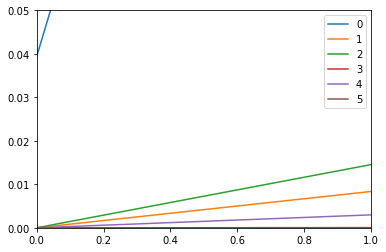

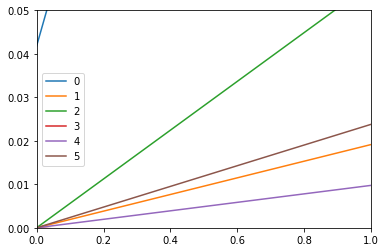

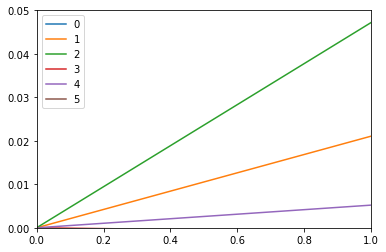

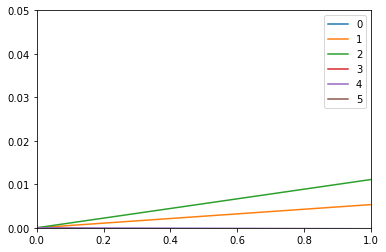

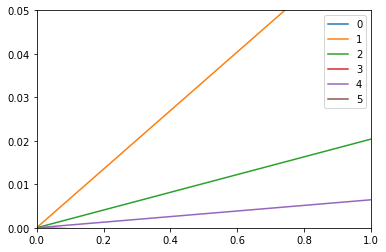

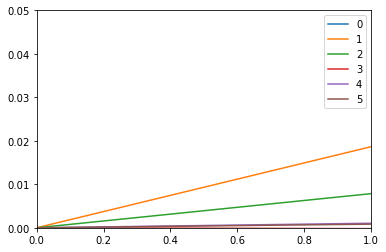

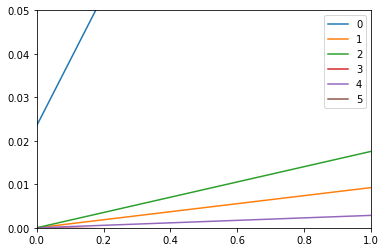

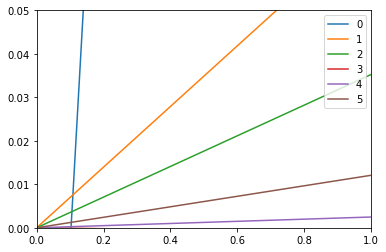

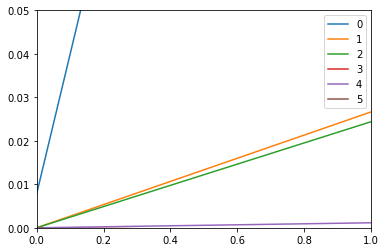

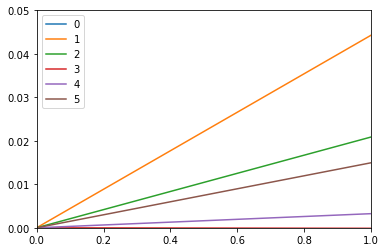

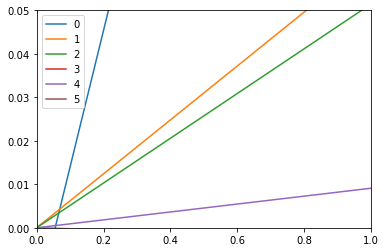

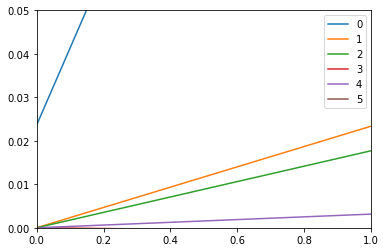

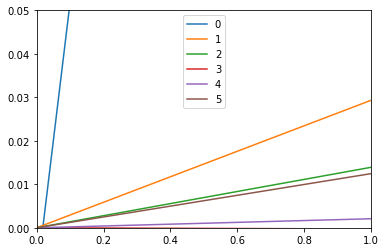

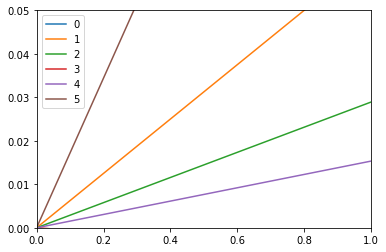

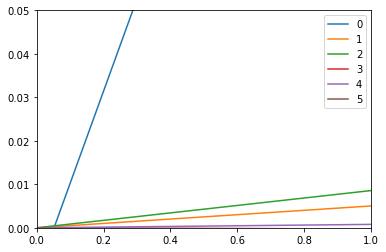

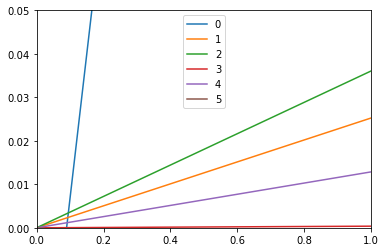

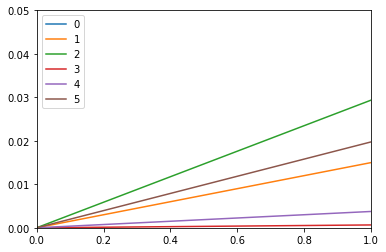

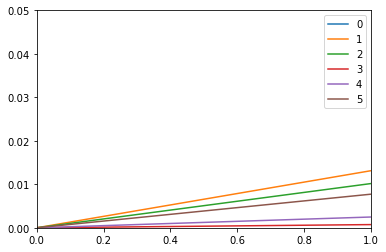

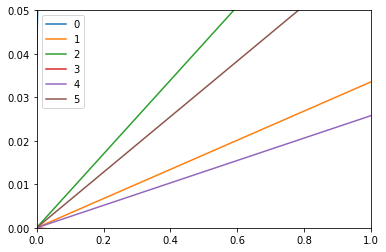

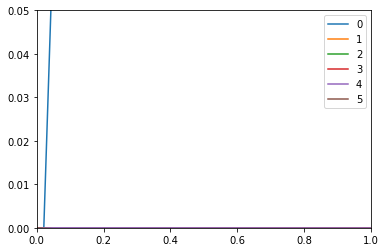

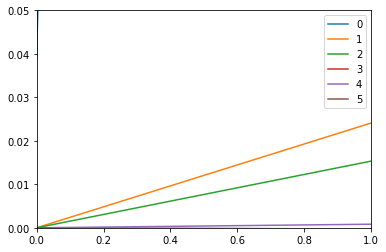

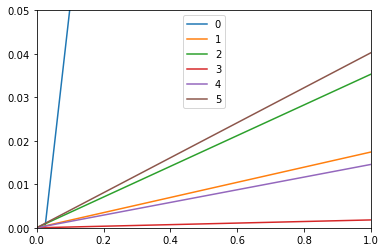

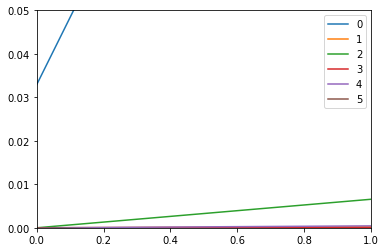

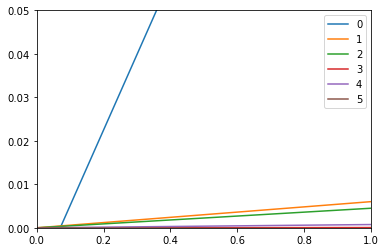

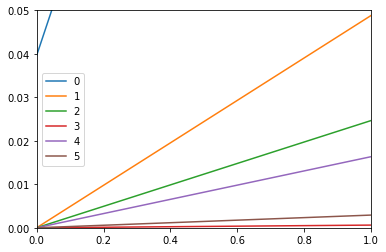

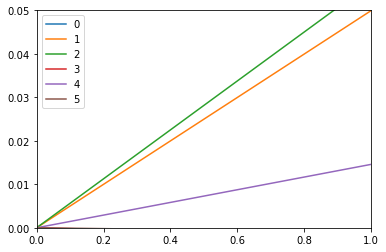

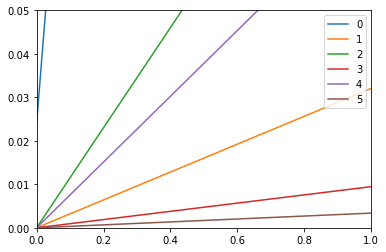

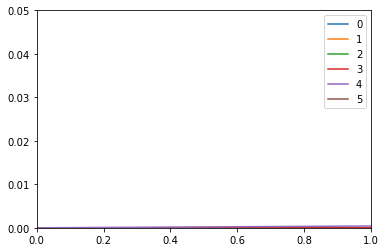

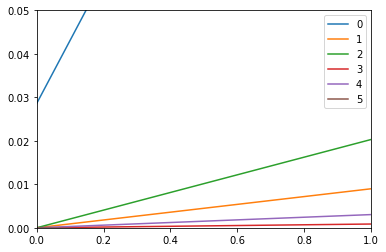

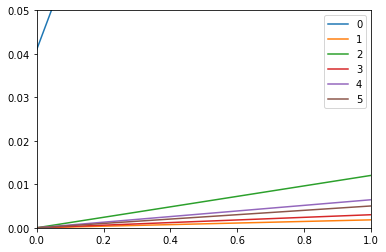

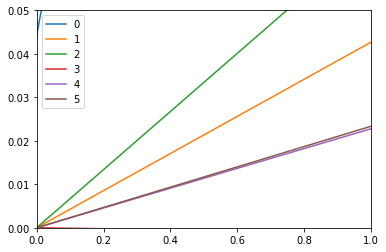

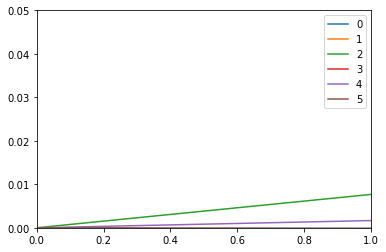

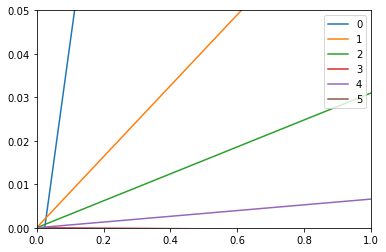

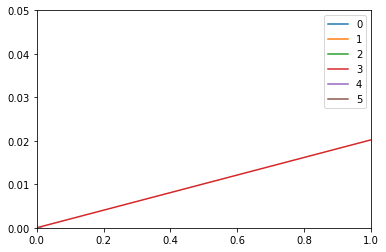

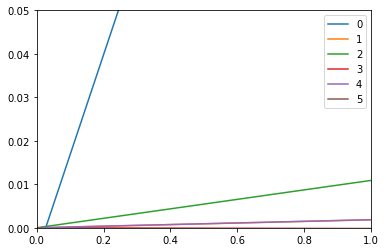

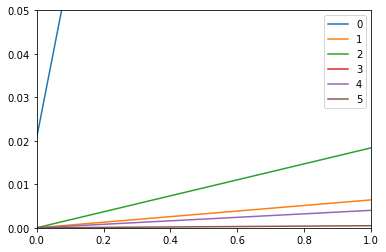

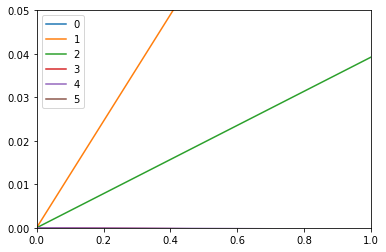

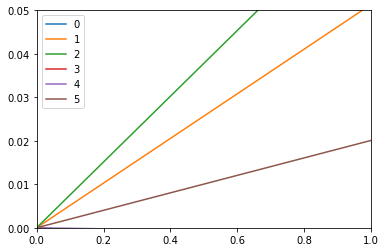

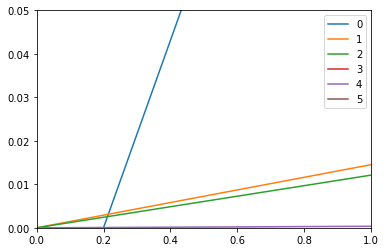

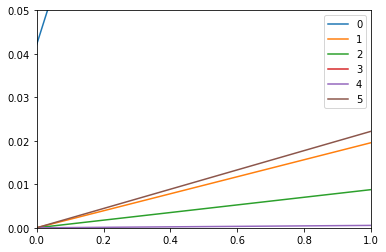

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,10))
for p in range(40):
    plt.figure()
    for l in range(6):
        plt.plot(np.mean(df['SaveXmod'][p][l],axis=0)/np.max(np.abs(np.mean(SaveXmod[p][l],axis=0))))    
    plt.legend([str(i) for i in range(6)])
    plt.ylim([0,0.05])
    plt.xlim([0,1])